### For the meeting

In [1]:
import sys

sys.path.insert(1, "/home/vinicius/storage1/projects/vanderbilt")

In [21]:
import os
from functools import partial

import emd
import igraph as ig
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import PyEMD
import scipy
import seaborn as sns
import skimage as ski
import umap
import xarray as xr
from frites.conn.conn_sliding_windows import define_windows
from frites.utils import parallel_func
from mne.time_frequency import tfr_array_morlet
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm

from config import metadata
from VUDA.emd import emd_vec
from VUDA.io.loadbinary import LoadBinary

#### Functions

In [5]:
def to_bin_freq(freqs, peaks):

    n_blocks, n_peaks = peaks.shape
    n_freqs = freqs.shape[0]

    def _for_peak(carry, peak):

        vec = jnp.zeros(n_freqs, dtype=int)
        indexes = jnp.stack(
            [jnp.argmin(jnp.abs(freqs - peak[i])) for i in range(n_peaks)]
        )
        vec = vec.at[indexes].set(1)
        return carry, vec

    _, vec = jax.lax.scan(_for_peak, None, peaks)

    return np.asarray(vec)

import numba as nb


# @nb.njit
def overlaps(theta_timings: list, gamma_timings: list):
    n_theta = len(theta_timings)
    n_gamma = len(gamma_timings)

    n_overlaps = np.empty(n_gamma, dtype=np.int64)

    for i in range(n_gamma):
        temp = np.logical_and(
            theta_timings[:, 0] - gamma_timings[i, 0] < 0,
            theta_timings[:, 1] - gamma_timings[i, 0] > 0,
        )

        temp = np.logical_and(
            temp,
            np.logical_and(
                theta_timings[:, 0] - gamma_timings[i, 1] < 0,
                theta_timings[:, 1] - gamma_timings[i, 1] > 0,
            ),
        )

        n_overlaps[i] = temp.sum()

    return n_overlaps

def replace_zeros_with_nan(arr):
    """
    Replaces zeros in a JAX array with NaNs.

    Parameters:
        arr (jax.numpy.ndarray): Input array.

    Returns:
        jax.numpy.ndarray: Array with zeros replaced by NaNs.
    """
    return jnp.where(arr == 0, jnp.nan, arr)


@partial(jax.vmap, in_axes=(None, 0))
def get_n_channels(labels: np.ndarray, label: int):
    """
    Calculates the maximum number of channels associated with a given label.

    Parameters:
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute channels for.

    Returns:
        int: Maximum number of channels associated with the given label.
    """
    return (labels == label).sum(0).max()


def nonzeromean(data: np.ndarray):
    """
    Computes the mean of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Mean of non-zero elements.
    """
    return data.sum() / (jnp.abs(data) > 0).sum()


def nonzerostd(data: np.ndarray):
    """
    Computes the standard deviation of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Standard deviation of non-zero elements.
    """
    non_zero_elements = data[data != 0]
    mean = non_zero_elements.mean()
    variance = ((non_zero_elements - mean) ** 2).mean()
    std_dev = np.sqrt(variance)
    return std_dev


def get_masked_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Masks the feature vector based on the given label.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to mask the feature vector.

    Returns:
        numpy.ndarray: Masked feature vector.
    """
    return (labels == label) * vector


@partial(jax.vmap, in_axes=(None, None, 0))
def average_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the average of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the average for.

    Returns:
        float: Average of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanmean(replace_zeros_with_nan(masked))


@partial(jax.vmap, in_axes=(None, None, 0))
def spread_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the standard deviation of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the standard deviation for.

    Returns:
        float: Standard deviation of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanstd(replace_zeros_with_nan(masked))


@partial(jax.vmap, in_axes=(None, None, 0))
def get_duration(times: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the duration of a particular label based on the provided times.

    Parameters:
        times (numpy.ndarray): Array of times.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the duration for.

    Returns:
        float: Duration of the label.
    """
    arr = get_masked_feature(times[None, :], labels, label)
    arr = replace_zeros_with_nan(arr)
    _min = jnp.nanmin(arr)
    _max = jnp.nanmax(arr)
    return _max - _min


@partial(jax.vmap, in_axes=(None, None, 0, None))
def get_spread(nobs: int, labels: np.ndarray, label: int, axes: tuple):
    """
    Computes the spatial spread of a particular label.

    Parameters:
        nobs (int): Number of channels.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the spatial spread for.

    Returns:
        numpy.ndarray: Array containing the minimum and maximum channel indices.
    """
    out = jnp.nonzero((labels == label).sum(axes), size=nobs, fill_value=jnp.nan)[0]
    ci, cf = jnp.nanmin(out), jnp.nanmax(out)
    return jnp.array([ci, cf], dtype=jnp.int16)

#### Load data

In [27]:
date = "10-20-2022"
monkey = "FN"
max_imfs = None
method = "eemd"
condition = "sleep"

base_path = os.path.expanduser(f"~/funcog/HoffmanData/{monkey}/{date}/")

composites_path = os.path.expanduser(
    os.path.join(
        base_path,
        f"composite_signals_{condition}_method_eemd_max_imfs_None_std_False.nc",
    )
)

ps_composites_path = os.path.expanduser(
    os.path.join(
        base_path,
        f"ps_composite_signals_{condition}_method_eemd_max_imfs_None_std_False.nc",
    )
)

In [28]:
composites = xr.open_dataset(composites_path)
ps_composites = xr.open_dataset(ps_composites_path)

#### Spectral bands channels

In [29]:
kernel = np.hanning(50)

In [30]:
channels = list(composites.keys())

In [31]:
peaks = []

for channel in tqdm(channels):
    data = ps_composites[channel].dropna("IMFs")
    freqs = data.freqs.data

    data_sm = xr.DataArray(
        scipy.signal.fftconvolve(data, kernel[None, None, :], mode="same", axes=2),
        dims=data.dims,
        coords=data.coords,
    )

    freqs = data.freqs.data

    n_blocks, n_IMFs, n_freqs = data.shape

    peaks += [freqs[data_sm.argmax("freqs").data]]

100%|█████████████████████████████████████████████████████████| 40/40 [00:16<00:00,  2.37it/s]


Text(0.5, 0, 'Frequency [Hz]')

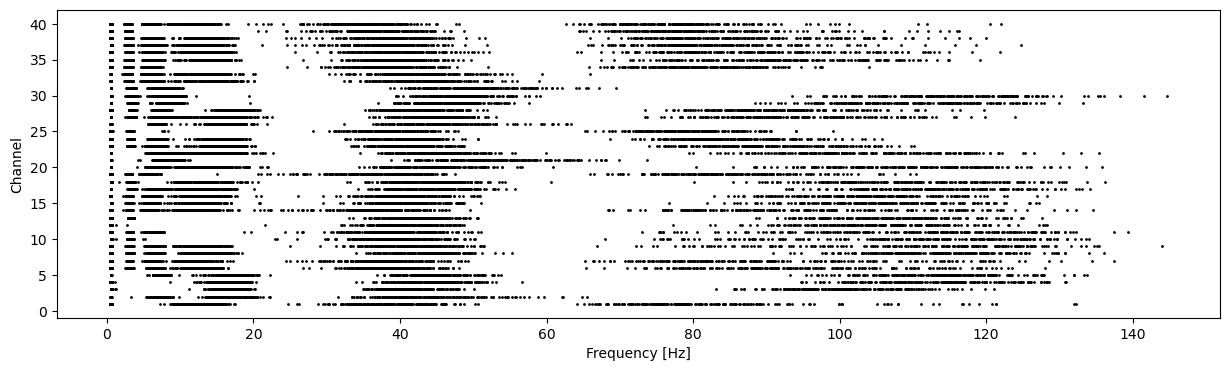

In [32]:
plt.figure(figsize=(15, 4))
d = []
for pos in range(len(channels)):
    x = peaks[pos].flatten()
    d += [x]
    plt.scatter(x, [pos + 1] * len(x), s=1, c="k")
plt.ylabel("Channel")
plt.xlabel("Frequency [Hz]")

#### Bursts

In [33]:
def replace_zeros_with_nan(arr):
    """
    Replaces zeros in a JAX array with NaNs.

    Parameters:
        arr (jax.numpy.ndarray): Input array.

    Returns:
        jax.numpy.ndarray: Array with zeros replaced by NaNs.
    """
    return jnp.where(arr == 0, jnp.nan, arr)


@partial(jax.vmap, in_axes=(None, 0))
def get_n_channels(labels: np.ndarray, label: int):
    """
    Calculates the maximum number of channels associated with a given label.

    Parameters:
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute channels for.

    Returns:
        int: Maximum number of channels associated with the given label.
    """
    return (labels == label).sum(0).max()


def nonzeromean(data: np.ndarray):
    """
    Computes the mean of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Mean of non-zero elements.
    """
    return data.sum() / (jnp.abs(data) > 0).sum()


def nonzerostd(data: np.ndarray):
    """
    Computes the standard deviation of non-zero elements in the input array.

    Parameters:
        data (numpy.ndarray): Input array.

    Returns:
        float: Standard deviation of non-zero elements.
    """
    non_zero_elements = data[data != 0]
    mean = non_zero_elements.mean()
    variance = ((non_zero_elements - mean) ** 2).mean()
    std_dev = np.sqrt(variance)
    return std_dev


def get_masked_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Masks the feature vector based on the given label.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to mask the feature vector.

    Returns:
        numpy.ndarray: Masked feature vector.
    """
    return (labels == label) * vector


@partial(jax.vmap, in_axes=(None, None, 0))
def average_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the average of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the average for.

    Returns:
        float: Average of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanmean(replace_zeros_with_nan(masked))


@partial(jax.vmap, in_axes=(None, None, 0))
def spread_feature(vector: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the standard deviation of non-zero elements in the masked feature vector, replacing zeros with NaNs.

    Parameters:
        vector (numpy.ndarray): Feature vector.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the standard deviation for.

    Returns:
        float: Standard deviation of non-zero elements in the masked feature vector.
    """
    masked = get_masked_feature(vector, labels, label)
    return jnp.nanstd(replace_zeros_with_nan(masked))


@partial(jax.vmap, in_axes=(None, None, 0))
def get_duration(times: np.ndarray, labels: np.ndarray, label: int):
    """
    Computes the duration of a particular label based on the provided times.

    Parameters:
        times (numpy.ndarray): Array of times.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the duration for.

    Returns:
        float: Duration of the label.
    """
    arr = get_masked_feature(times[None, :], labels, label)
    arr = replace_zeros_with_nan(arr)
    _min = jnp.nanmin(arr)
    _max = jnp.nanmax(arr)
    return _max - _min


@partial(jax.vmap, in_axes=(None, None, 0, None))
def get_spread(nobs: int, labels: np.ndarray, label: int, axes: tuple):
    """
    Computes the spatial spread of a particular label.

    Parameters:
        nobs (int): Number of channels.
        labels (numpy.ndarray): Array of labels.
        label (int): Label to compute the spatial spread for.

    Returns:
        numpy.ndarray: Array containing the minimum and maximum channel indices.
    """
    out = jnp.nonzero((labels == label).sum(axes), size=nobs, fill_value=jnp.nan)[0]
    ci, cf = jnp.nanmin(out), jnp.nanmax(out)
    return jnp.array([ci, cf], dtype=jnp.int16)

In [34]:
def load_bursts(channel: str = None, rythm: str = "slow"):
    assert rythm in ["slow", "fast"]
    _base = os.path.join(base_path, "bursts")
    fname = f"labeled_bursts_{rythm}_{channel}_{condition}_method_eemd_max_imfs_None_std_False.nc"
    fname = os.path.join(_base, fname)
    return xr.load_dataarray(fname)

In [35]:
bursts = (load_bursts(channel="channel31", rythm="slow")).astype(int)

In [36]:
get_spectral_spread = lambda nfreqs, labels, label: get_spread(
    nfreqs, labels, label, (1)
)
get_temporal_spread = lambda ntimes, labels, label: get_spread(
    ntimes, labels, label, (0)
)


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_spectral_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, n_freqs: int
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_spectral_spread(
        n_freqs,
        labels[block],
        unique_labels,
    )


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_temporal_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, n_times: int
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_temporal_spread(
        n_times,
        labels[block],
        unique_labels,
    )


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_duration_blocks(
    block: int, labels: jnp.ndarray, max_label: int, times: np.ndarray
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return get_duration(times, labels[block], unique_labels)


@partial(jax.vmap, in_axes=(0, None, None, None))
def get_average_spread_blocks(
    block: int, labels: jnp.ndarray, max_label: int, vector: np.ndarray
):
    unique_labels = jnp.unique(labels[block], size=max_label, fill_value=-1)[1:]

    return (
        average_feature(vector, labels[block], unique_labels),
        spread_feature(vector, labels[block], unique_labels),
    )

In [37]:
nblocks, nfreqs, ntimes = bursts.shape
times = bursts.times.data
freqs = bursts.freqs.data

blocks_idx = jnp.arange(nblocks)

mu_time, sig_time = get_average_spread_blocks(
    blocks_idx, jnp.array(bursts.data), bursts.data.max(), bursts.times.data
)

mu_freq, sig_freq = get_average_spread_blocks(
    blocks_idx, jnp.array(bursts.data), bursts.data.max(), bursts.freqs.data[:, None]
)

duration = get_duration_blocks(
    blocks_idx, jnp.array(bursts.data), bursts.data.max(), bursts.times.data
)

temp_spread = get_temporal_spread_blocks(
    blocks_idx, jnp.array(bursts.data), bursts.data.max(), ntimes
)

spec_spread = get_spectral_spread_blocks(
    blocks_idx, jnp.array(bursts.data), bursts.data.max(), nfreqs
)

mu_time, sig_time, duration, temp_spread, mu_freq, sig_freq, spec_spread = (
    np.array(mu_time),
    np.array(sig_time),
    np.array(duration),
    np.array(temp_spread),
    np.array(mu_freq),
    np.array(sig_freq),
    np.array(spec_spread),
)

features = [mu_time, sig_time, duration, temp_spread, mu_freq, sig_freq, spec_spread]

#  features = np.hstack(features)

2024-03-08 17:00:44.659592: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 25385500672
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [38]:
features_names = [
    "average(time)",
    "std(time)",
    "duration",
    "temp_spread",
    "average(freq)",
    "sig(freq)",
    "spec_spread",
]

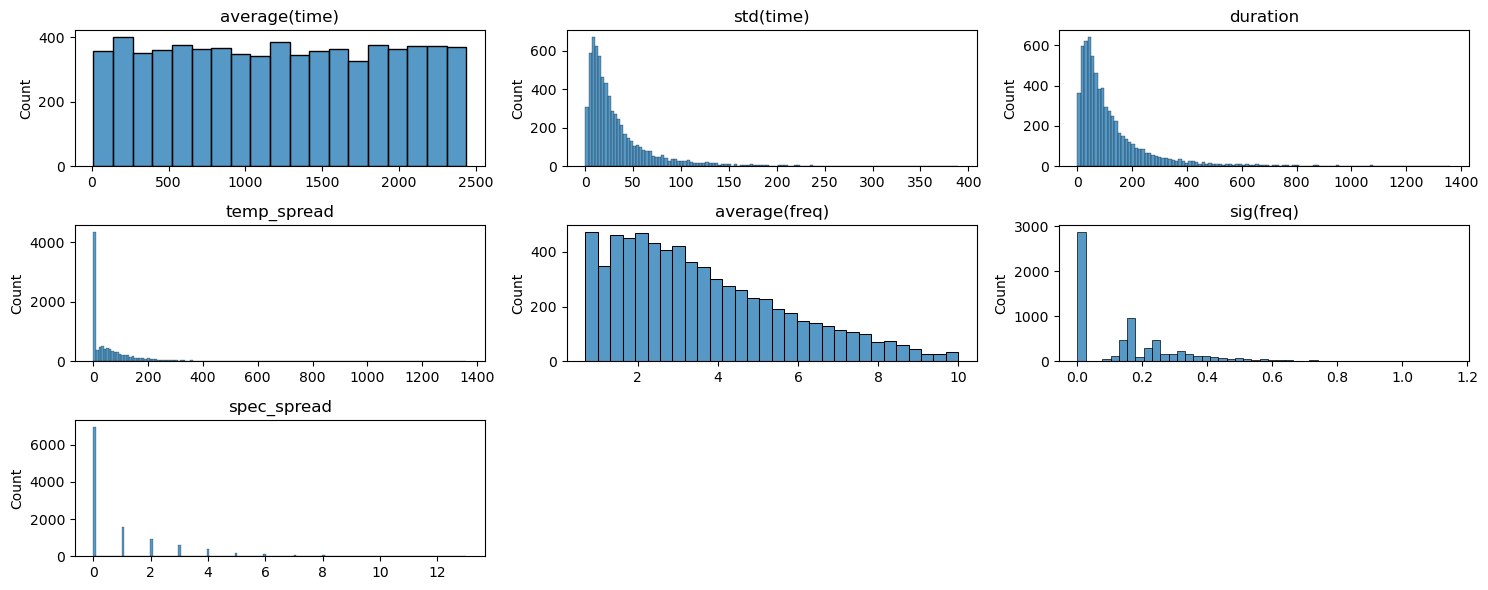

In [39]:
plt.figure(figsize=(15, 6))
for i in range(len(features_names)):
    data = features[i]
    if data.ndim == 3:
        data = np.diff(data.reshape(-1, 2), axis=1)
    data = data.flatten()
    data = data[~np.isnan(data)]
    plt.subplot(3, 3, i + 1)
    sns.histplot(data=data)
    plt.title(features_names[i])
plt.tight_layout()